In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [14]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "PlantVillage",
  shuffle=True,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [15]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [16]:
len(dataset)

68

2025-05-10 22:35:47.373774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


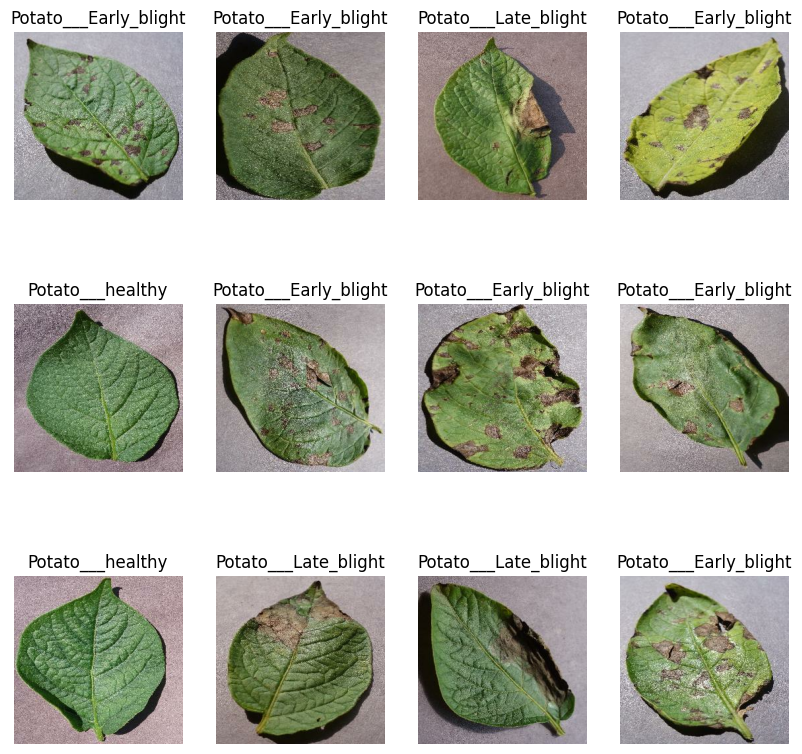

In [28]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
  for i in range(12):
      plt.subplot(3, 4, i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[labels_batch[i]])
      plt.axis("off")


In [ ]:
80% ==> training
20% ==> 10% validation, 10% test

In [29]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [30]:
train_ds = dataset.take(54)
len(train_ds)

54

In [32]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [33]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [34]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [35]:
val_ds = test_ds.skip(6)
len(val_ds)

8

In [36]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffed=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffed:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    

    return train_ds, val_ds, test_ds

In [37]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [38]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [ ]:
# caching & prefetching
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
